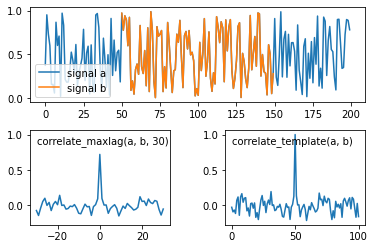

In [1]:
# Copyright 2018, Tom Eulenfeld, MIT license
"""
Normalized cross-correlation or cross-correlation with specified maximum lag

This code is published in a similar version in ObsPy's
cross-correlation module (v1.1.0).
"""

import numpy as np
import scipy.signal


def _pad_zeros(a, num, num2=None):
    """Pad num zeros at both sides of array a"""
    if num2 is None:
        num2 = num
    hstack = [np.zeros(num, dtype=a.dtype), a, np.zeros(num2, dtype=a.dtype)]
    return np.hstack(hstack)


def _xcorr_padzeros(a, b, shift, method):
    """
    Cross-correlation using SciPy with mode='valid' and precedent zero padding
    """
    if shift is None:
        shift = (len(a) + len(b) - 1) // 2
    dif = len(a) - len(b) - 2 * shift
    if dif > 0:
        b = _pad_zeros(b, dif // 2)
    else:
        a = _pad_zeros(a, -dif // 2)
    return scipy.signal.correlate(a, b, 'valid', method)


def _xcorr_slice(a, b, shift, method):
    """
    Cross-correlation using SciPy with mode='full' and subsequent slicing
    """
    mid = (len(a) + len(b) - 1) // 2
    if shift is None:
        shift = mid
    if shift > mid:
        # Such a large shift is not possible without zero padding
        return _xcorr_padzeros(a, b, shift, method)
    cc = scipy.signal.correlate(a, b, 'full', method)
    return cc[mid - shift:mid + shift + len(cc) % 2]


def get_lags(cc):
    """
    Return array with lags

    :param cc: Cross-correlation returned by correlate_maxlag.
    :return: lags
    """
    mid = (len(cc) - 1) / 2
    if len(cc) % 2 == 1:
        mid = int(mid)
    return np.arange(len(cc)) - mid


def correlate_maxlag(a, b, maxlag, demean=True, normalize='naive',
                     method='auto'):
    """
    Cross-correlation of two signals up to a specified maximal lag.

    This function only allows 'naive' normalization with the overall
    standard deviations. This is a reasonable approximation for signals of
    similar length and a relatively small maxlag parameter.
    :func:`correlate_template` provides correct normalization.

    :param a,b: signals to correlate
    :param int maxlag: Number of samples to shift for cross correlation.
        The cross-correlation will consist of ``2*maxlag+1`` or
        ``2*maxlag`` samples. The sample with zero shift will be in the middle.
    :param bool demean: Demean data beforehand.
    :param normalize: Method for normalization of cross-correlation.
        One of ``'naive'`` or ``None``
        ``'naive'`` normalizes by the overall standard deviation.
        ``None`` does not normalize.
    :param method: correlation method to use.
        See :func:`scipy.signal.correlate`.

    :return: cross-correlation function.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    if demean:
        a = a - np.mean(a)
        b = b - np.mean(b)
    # choose the usually faster xcorr function for each method
    _xcorr = _xcorr_padzeros if method == 'direct' else _xcorr_slice
    cc = _xcorr(a, b, maxlag, method)
    if normalize == 'naive':
        norm = (np.sum(a ** 2) * np.sum(b ** 2)) ** 0.5
        if norm <= np.finfo(float).eps:
            # norm is zero
            # => cross-correlation function will have only zeros
            cc[:] = 0
        elif cc.dtype == float:
            cc /= norm
        else:
            cc = cc / norm
    elif normalize is not None:
        raise ValueError("normalize has to be one of (None, 'naive'))")
    return cc


def _window_sum(data, window_len):
    """Rolling sum of data"""
    window_sum = np.cumsum(data)
    # in-place equivalent of
    # window_sum = window_sum[window_len:] - window_sum[:-window_len]
    # return window_sum
    np.subtract(window_sum[window_len:], window_sum[:-window_len],
                out=window_sum[:-window_len])
    return window_sum[:-window_len]


def correlate_template(data, template, mode='valid', demean=True,
                       normalize='full', method='auto'):
    """
    Normalized cross-correlation of two signals with specified mode.

    If you are interested only in a part of the cross-correlation function
    around zero shift use :func:`correlate_maxlag` which allows to
    explicetly specify the maximum lag.

    :param data,template: signals to correlate. Template array must be shorter
        than data array.
    :param normalize:
        One of ``'naive'``, ``'full'`` or ``None``.
        ``'full'`` normalizes every correlation properly,
        whereas ``'naive'`` normalizes by the overall standard deviations.
        ``None`` does not normalize.
    :param mode: correlation mode to use.
        See :func:`scipy.signal.correlate`.
    :param bool demean: Demean data beforehand.
        For ``normalize='full'`` data is demeaned in different windows
        for each correlation value.
    :param method: correlation method to use.
        See :func:`scipy.signal.correlate`.

    :return: cross-correlation function.

    .. note::
        Calling the function with ``demean=True, normalize='full'`` (default)
        returns the zero-normalized cross-correlation function.
        Calling the function with ``demean=False, normalize='full'``
        returns the normalized cross-correlation function.
    """
    data = np.asarray(data)
    template = np.asarray(template)
    lent = len(template)
    if len(data) < lent:
        raise ValueError('Data must not be shorter than template.')
    if demean:
        template = template - np.mean(template)
        if normalize != 'full':
            data = data - np.mean(data)
    cc = scipy.signal.correlate(data, template, mode, method)
    if normalize is not None:
        tnorm = np.sum(template ** 2)
        if normalize == 'naive':
            norm = (tnorm * np.sum(data ** 2)) ** 0.5
            if norm <= np.finfo(float).eps:
                cc[:] = 0
            elif cc.dtype == float:
                cc /= norm
            else:
                cc = cc / norm
        elif normalize == 'full':
            pad = len(cc) - len(data) + lent
            if mode == 'same':
                pad1, pad2 = (pad + 2) // 2, (pad - 1) // 2
            else:
                pad1, pad2 = (pad + 1) // 2, pad // 2
            data = _pad_zeros(data, pad1, pad2)
            # in-place equivalent of
            # if demean:
            #     norm = ((_window_sum(data ** 2, lent) -
            #              _window_sum(data, lent) ** 2 / lent) * tnorm) ** 0.5
            # else:
            #      norm = (_window_sum(data ** 2, lent) * tnorm) ** 0.5
            # cc = cc / norm
            if demean:
                norm = _window_sum(data, lent) ** 2
                if norm.dtype == float:
                    norm /= lent
                else:
                    norm = norm / lent
                np.subtract(_window_sum(data ** 2, lent), norm, out=norm)
            else:
                norm = _window_sum(data ** 2, lent)
            norm *= tnorm
            if norm.dtype == float:
                np.sqrt(norm, out=norm)
            else:
                norm = np.sqrt(norm)
            mask = norm <= np.finfo(float).eps
            if cc.dtype == float:
                cc[~mask] /= norm[~mask]
            else:
                cc = cc / norm
            cc[mask] = 0
        else:
            msg = "normalize has to be one of (None, 'naive', 'full')"
            raise ValueError(msg)
    return cc


def _test():
    import matplotlib.pyplot as plt

    np.random.seed(42)
    N = 200
    maxlag = 30
    a = np.random.random(N)
    start = N // 4
    b = a[start:-start]
    cc1 = correlate_maxlag(a, b, maxlag)
    cc2 = correlate_template(a, b)

    grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
    ax1 = plt.subplot(grid[0, 0:])
    ax2 = plt.subplot(grid[1, 0])
    ax3 = plt.subplot(grid[1, 1], sharey=ax2)
    ax1.plot(np.arange(len(a)), a, label='signal a')
    ax1.plot(np.arange(len(b)) + start, b, label='signal b')
    ax2.plot(get_lags(cc1), cc1)
    ax3.plot(cc2)
    ax1.legend(loc=3)
    kw = dict(xy=(0.05, 0.95), xycoords='axes fraction', va='top')
    ax2.annotate('correlate_maxlag(a, b, {})'.format(maxlag), **kw)
    ax3.annotate('correlate_template(a, b)', **kw)
    plt.savefig('xcorr_example.png')
    plt.show()


if __name__ == '__main__':
    _test()

In [3]:
arr = np.array([9, 5, 8])

In [5]:
_pad_zeros(arr, 5)

array([0, 0, 0, 0, 0, 9, 5, 8, 0, 0, 0, 0, 0])

2.15